# 9장 비지도학습
주요 내용
- 군집화
- k-평균
- DBSCAN
- 가우시안 혼합

## 기본설정

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 9.1 군집화
분류 대 군집화

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()

X = data.data
y = data.target

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

아래 코드는 분류와 군집화의 차이를 보여주는 그림을 그린다.
- 왼편 : 각 샘플이 속하는 품종에 따른 분류
- 오른편 : 지정된 기준에 따라 비슷한 샘플들끼리 그룹짓기

Saving figure classification_vs_clustering_plot


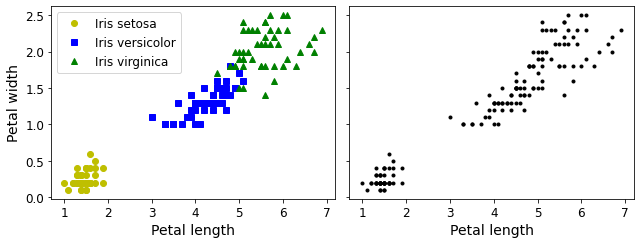

In [5]:
plt.figure(figsize=(9, 3.5))

# 왼편 그림: 분류
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

# 오른편 그림: 군집화
plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

꽃잎 길이와 너비만으로는 두 개의 군집으로만 구분이 가능해 보인다. 하지만 꽃잎의 길이와 너비와 더불어 꽃받침의 길이와 너비까지 포함한 네 개의 특성을 모두 사용하여 후반부에서 가우시안 혼합 모델을 이용하여 세 개의 군집으로 나눌 수 있다.

In [6]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

실제 타깃을 이용한 분류와 직접 비교하면 다음과 같으며, 버시컬러와 버지니카 품종의 군집이 거의 정확하게 구분된 것을 확인할 수 있다.

Saving figure classification_vs_clustering_plot


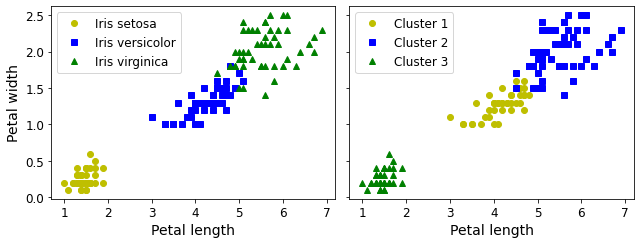

In [7]:
plt.figure(figsize=(9, 3.5))

# 왼편 그림: 실제 품종별 분류
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

# 오른편 그림: 3개의 군집
plt.subplot(122)
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "yo", label="Cluster 1")   # 2번 군집: 세토사
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "bs", label="Cluster 2")   # 0번 군집: 버시컬러
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "g^", label="Cluster 3")   # 1번 군집: 버지니카
plt.xlabel("Petal length", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

군집화의 정확도를 확인하기 위해 군집별로 가장 많이 포함된 품종, 즉, 품종의 최빈값(mode)를 확인한다.
아래 코드는 사이파이(scipy)의 통계 모듈에 포함되어 있는 `mode()` 함수를 이용하여 각 군집별 최빈값을 확인한 후에 해당 최빈값과 군집 인덱스를 연결(mapping)한다.

In [8]:
from scipy import stats

mapping = {}

for class_id in np.unique(y):                   # 품종 아이디: 0, 1, 2
    mode, _ = stats.mode(y_pred[y==class_id])   # mode: 지정된 품종이 가장 많이 포함된 군집 인덱스
    mapping[mode[0]] = class_id                 # 군집 인덱스와 품종 연결

최종 결과는 다음과 같다.
- 2번 인덱스 군집: 세토사(0)가 제일 많음.
- 0번 인덱스 군집: 버시컬러(1)가 제일 많음.
- 1번 인덱스 군집: 버지니카(2)가 제일 많음.

In [9]:
mapping

{0: 2, 1: 0, 2: 1}

`mapping`을 이용하여 군집 인덱스를 품종 인덱스로 변경한 후에 군집화의 정확도를 측정하면 96.7%가 나온다.

In [10]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

### K-평균
먼저 2,000개의 데이터 샘플을 생성한다. 생성되는 데이터는 지정된 5개의 센터를 중심으로 지정된 표준편차를 따르는 원 모양의 데이터 군집을 이룬다. 또한 각각의 군집은 거의 동일한 크기를 갖는다.

- 5개의 센터와 표준편차

In [11]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

`make_blobs()`함수가 앞서 설명한 방식으로 데이터를 생성한다.

In [12]:
from sklearn.datasets import make_blobs

In [13]:
X, _ = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

산점도를 그리면 다음과 같다.

In [14]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


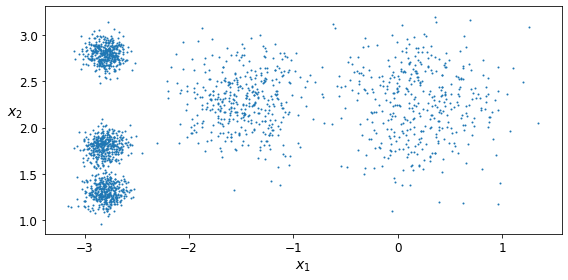

In [15]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

#### 군집화 훈련과 예측
사이킷런 `KMeans` 모델의 `fit()` 메서드는 각 군집의 중심을 잡은 다음에 모든 샘플에 대해 가장 가까운 센트로이드를 중심으로하는 군집을 이루도록 한다. 다만, 센트로이드를 몇개로 할 것인지 먼저 지정해야하며, 여기서는 5개를 사용하여 훈련시킨다.

In [16]:
from sklearn.cluster import KMeans

In [17]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

훈련 결과 `kmeans.labels_` 속성에 각 훈련 샘플에 대한 군집 인덱스가 저장된다.

In [18]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

각 군집의 중심, 즉 5개의 센트로이드의 좌표는 다음과 같다.

In [19]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

`predict()`메서드를 이용하여 새로운 데이터에 대한 군집 예측도 가능하다.

In [20]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### 결정경계
군집을 나누는 결정경계를 그려보면 브로노이 다이어그램이 생성된다.

`plot_data()`함수는 여기서만 사용되는 기본값이 지정된 산점도를 그린다.

In [21]:
# 산점도 그리기

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

`plot_centroids()`함수는 센트로이드를 시각화한다.
- `weights=None` 옵션: 특정 가중치 이상의 센트로이드만 그리도록 하는 설정. 나중에 가우시안 혼합 모델을 시각화할 때 사용됨.

In [22]:
# 센트로이드 그리기
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]

    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

`plot_decision_boundaries()` 함수는 결정경계를 시각화한다.
- `clusterer` : 훈련된 군집화 모델 객체
- `X` : 훈련 세트

In [23]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    
    # 바탕화면 그리기
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    # 훈련 샘플 산점도 그리기
    plot_data(X)
    
    # 센트로이드 그리기
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    # 기타: x, y 축 레이블
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


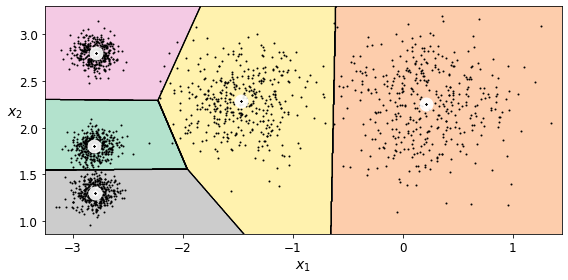

In [24]:
plt.figure(figsize=(8, 4))

plot_decision_boundaries(kmeans, X)

save_fig("voronoi_plot")
plt.show()

경계 근처의 일부 데이터가 잘못된 군집에 포함되긴했지만, 전반적으로 군집이 잘 형성되었다.
### 군집화와 차원축소
지금까지 살펴 보았듯이 k-평균 모델 객체의 `labels_` 속성은 각 샘플에 대해 가장 가까운 센트로이드를 중심으로 하는 군집의 (작위적으로 지정된) 인덱스를 저장하며, 이를 이용하여 `predict()` 메서드는 샘플이 속하는 군집의 인덱스를 반환한다. 이런 방식으로 군집화가 **하드 군집화(hard clustering)**이다.

반면에 **소프트 군집화(soft clustering)**는 샘플과 각 군집 사이의 관계를 점수로 부여한다. 점수는 예를 들어 각 군집과 샘플사이의 거리 또는 5장에서 소개한 가우시안 방사기저 함수를 이용한 유사도 점수 등이 사용 될 수 있다. k-평균 모델 객체의 `transform()` 메서드는 샘플과 각 센트로이드 사이의 (유클리드)거리를 점수로 사용한다.

아래 코드는 네 개의 새 데이터를 변환하는 것을 보여준다.

In [25]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

앞서 설명한 대로 각 샘플에 대한 반환값은 각 센트로이드로부터의 (유클리드) 거리임을 아래와 같이 확인할 수 있다.
- `np.tile()`: 주어진 어레이를 타일 모양의 지정된 형식으로 복제해서 이어붙이는 함수

In [26]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

k-평균 모델의 transform() 메서드는 결론적으로 기존 -차원의 데이터셋을 **비선형**적으로 -차원의 데이터셋으로 변환하는 비선형 **차원축소** 기법으로 사용될 수 있다.

참고: 국소적 선형 임베딩 처럼 차원축소 기법을 군집화에 활용할 수도 있다.

#### k-평균 알고리즘
k-평균 알고리즘은 가장 빠르며 가장 간단한 군집화 알고리즘 중 하나이다.

- $k$ 개의 센트로이드 무작위 지정.
- 센트로이드의 위치가 특정 위치에 수렴할 때까지 아래 과정 반복
  - 모든 샘플에 대해 가장 가까운 센트로이드 지정
  -4 각각의 센트로이드와 연결된 샘플들의 평균으로 해당 센트로이도 위치 수정
#### 사이킷런의 `KMeans` 클래스
`KMeans` 클래스의 기본 옵션 중 몇 가지는 다음과 같다.

- `init='k-means++'`: 초기화 알고리즘.
  - `'random'`을 사용할 경우 무작위 지정.
  - `'k-means++'`: 센트로이드 간의 거리를 최대한 크게하는 알고리즘. 기본값으로 사용됨.
- `n_init=10`: 센트로이드 반복 지정 횟수. 기본값은 10.
- `algorithm='elkan'`: k-평균 알고리즘.
  - `'full'`: 앞서 설명한 알고리즘
  - `'elkan'`: 개선된 알고리즘
  - `'auto'`: 기본적으로 'elkan' 선택.
- `max_iter=300`: 초기화된 센트로이드 위치 반복 업데이트 횟수.
여기서는 예시를 위해 아래 옵션을 대신 사용한다.

- `init="random"`
- `n_init=1`
- `algorithm="full"`
- `max_iter`: 1, 2, 3

In [27]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)

kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)

kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

각 단계별 결정경계와 센트로이드의 변화는 다음과 같다.

Saving figure kmeans_algorithm_plot


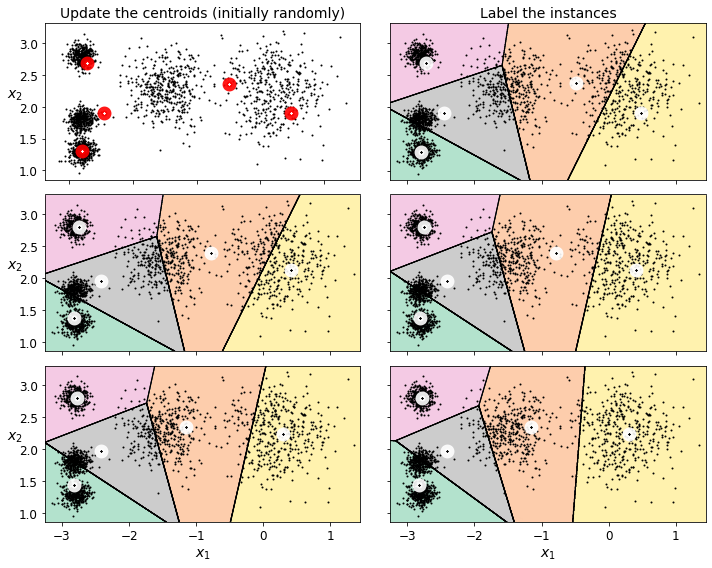

In [28]:
plt.figure(figsize=(10, 8))

# 맨 위 왼편
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

# 맨 위 오른편
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

# 가운데 왼편
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

# 가운데 오른편
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# 맨 아래 왼편
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

# 맨 아래 오른편
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### 센트로이드 초기화 문제와 해결법
#### 초기화 문제
초기화가 무작위로 이루어질 경우 적절하지 않은 군집화를 얻을 수 있다. 아래 코드는 두 개의 나쁜 경우를 잘 보여준다.

`plot_clusterer_comparison()`함수는 두개의 결정경계 그래프를 동시에 그려준다.

In [29]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

아래 두 개의 그래프는 바로 이전의 경우처럼 센트로이드 초기화를 무작위로 딱 한 번 사용한 결과를 보여준다. 두 경우 모두 적절치 않는 모델을 생성한다.

Saving figure kmeans_variability_plot


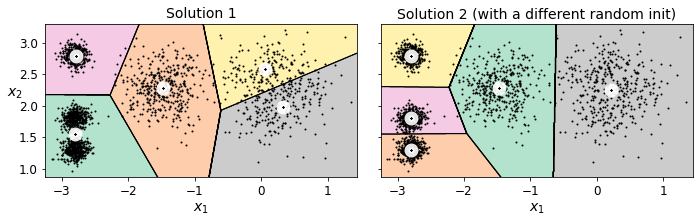

In [30]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

#### 관성(inertia, 이너셔)
비지도 학습인 k-평균 모델의 성능을 **관성(inertia)**을 이용하여 측정한다.
- 관성: 각 훈련 샘플과 가장 가까운 센트로이드 사이의 거리를 모두 합한 값
- `inertia_` 속성에 지정됨.

In [31]:
kmeans.inertia_

211.5985372581684

In [32]:
X_dist = kmeans.transform(X)  # 각 샘플과 센트로이드들 사이의 거리

np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)   # 팬시 인덱싱 활용

211.59853725816868

`score()` 메서드는 관성의 음숫값을 반환한다. 이유는 "더 높은 점수가 더 좋다"의 원칙을 따라야 하기 때문이다.

In [33]:
kmeans.score(X)

-211.59853725816836

#### 초기화 반복
무작위 초기화 문제를 해결하기 위해 k-평균 알고리즘의 초기화를 여러 번 실행한 다음에 가장 낮은 관성을 보이는 모델을 최종 모델로 선택하면 되며, 실제로 이 옵션(`n_init=10`)이 앞서 설명한 것처럼 K-Means 모델의 기본 하이퍼파라미터 값으로 설정되어 있다.

아래에서 확인 할 수 있듯이 기본 하이퍼파라미터를 사용한 `kmeans`의 관성이 한 번의 센트로이드 초기화를 사용하는 모델들의 관성보다 낮다.

In [34]:
kmeans_rnd_init1.inertia_

219.43539442771396

In [35]:
kmeans_rnd_init2.inertia_

211.5985372581684

실제로 `n_init=10`으로 설정할 경우 앞서 살펴본 좋은 모델과 비슷한 결과를 얻는다.

In [36]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

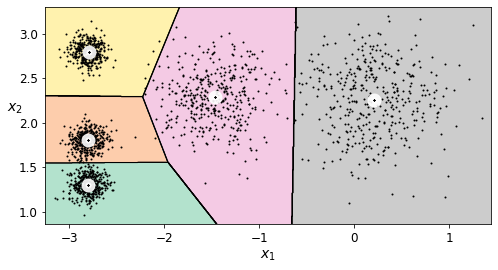

In [37]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

관성 점수도 거의 최저다.

#### K-Means++ 알고리즘
센트로이드 무작위 초기화 문제의 보다 근본적인 해결책이 아서(David Arthur)와 바실비츠키(Sergei Vassilviskii)의 2006년 논문에서 제시되었다. 기본 아이디어는 기존 센트로이드들과의 거리가 멀 수록 다음 센트로이드로 선택될 확률이 높아지도록 하는 것이다.

1. 균등분포를 따르면서 임의로 하나의 센트로이드 $c_1$ 선택 후 $k$개의 센트로이드를 지정할 때까지 아래 과정 반복
2. $c_1, ...,c_{i-1}$이 이미 선택되었다고 가정.

  A. 아래의 확률로 새로운 센트로이드 $c_i$로 $x_i$ 선택:
$$ \frac{D(x_i)^2} { \sum_{j=i}^{m} D(x_j)^2} $$
  B. $D(x_j):x_j$와 이미 선택된 $c_1, ...,c_{i-1}$ 중에서 가장 가까운 센트로이드 사이의 거리
  $$ D(x_j) = min_{k<i} \left\| x_j - c_k \right\| $$

확률 계산으로 인해 초기화 비용이 좀 더 많이 들어가긴 하지만 결과적으로 초기화 횟수(`n_init`)를 획기적으로 줄일 수 있는 장점이 보다 크다. 따라서 사이킷런의 KMeans 모델의 기본값으로 사용된다.

데이터를 생성할 때 사용된 군집의 실제 중심과 `kmeans` 모델이 찾아낸 군집의 센트로이드가 매우 비슷함을 아래 코드에서 확인할 수 있다.

In [38]:
blob_centers

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.8,  1.8],
       [-2.8,  2.8],
       [-2.8,  1.3]])

In [39]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

#### `init` 하이퍼파라미터 활용
센트로이드에 대한 좋은 후보값을 알 수 있다면 `init` 하이퍼파라미터의 값으로 센트로이드의 좌표를 지정하여 훈련하다 보면 좋은 결과를 얻게 됨을 아래 코드가 잘 보여준다.

In [40]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### 개선된 k-평균 알고리즘과 미니배치 k-평균
#### 개선된 k-평균 알고리즘
k-평균 알고리즘은 각 훈련 샘플과 센트로이드 사이의 거리르 계산하여 가장 짧은 거리의 센트로이드를 중심으로 하는 군집에 해당 샘플을 연결한다. 하지만 엘칸(Charles Elkan)의 2003 논문이 거리 계산을 획기적으로 줄이는 개선된 알고리즘을 제시한다.

사이킷런의 `KMeans` 모델은 `algorithm='elkan'`을 기본 옵션으로 사용한다. 그런데 엘칸 알고리즘은 희소 데이터(sparse data)에 대해서는 잘 작동하지 않아 모든 거리를 계산하는 `algorithm='full'` 옵션이 희소 데이터에 대해 자동으로 선택된다.

아래 코드는 두 방식의 시간차이를 보여준다. 하지만 데이터셋이 크지 않기 때문에 시간차이가 크지 않아 보인다.

In [41]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

50 loops, best of 5: 76.4 ms per loop


In [42]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

50 loops, best of 5: 44.5 ms per loop


미니배치 K-평균
사이킷런의 `MiniBatchKMeans` 모델은 미니배치 학습을 지원한다.
- `batch_size=100`: 배치 크기 지정. 기본값은 100.

In [43]:
from sklearn.cluster import MiniBatchKMeans

In [44]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [45]:
minibatch_kmeans.inertia_

211.65239850433215

#### 훈련 세트가 많이 큰 경우: `memmap`클래스 활용
8장 주성분 분석에서 소개한 넘파이 `memmap` 클래스를 이용하여 MNIST 데이터셋을 대상으로 미니배치 k_평균 모델을 훈련해보자.

먼저 MNIST 데이터셋을 불러온다.

In [46]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)   # 타깃의 자료형을 변환해줄 필요 있음

훈련 세트와 테스트 세트로 구분한다.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

`memmap` 객체로 지정한다.

In [48]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

`MiniBatchKMeans` 모델을 훈련한다.

In [49]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

### 훈련 세트가 너무 큰 경우: `partial_fit()` 활용
데이터셋이 너무 크면 memmap 클래스조차 활용하지 못할 수 있다. 이럴 때는 메모리가 아닌 다른 저장 장치로부터 필요한 만큼의 데이터 배치(묶음)를 불러오는 함수를 이용하여 수동으로 미니배치 학습을 구현해야 한다. 즉, 아래 내용을 직접 구현해야 한다.

- 초기화 반복
- 최적 모델 기억하기, 즉, 최소 관성값을 갖는 모델 기억하기

아래 함수는 지정된 크기 만큼의 데이터를 무작위로 선택해서 전달한다.

In [50]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

다음 조건에 맞게 미니배치 모델을 훈련한다.

In [51]:
k = 5               # 센트로이드 개수
n_init = 10         # 센트로이드 초기화 횟수
n_iterations = 100  # 센트로이드 조정 횟수
batch_size = 100    # 배치 크기
init_size = 500     # k-평균++ 알고리즘의 초기화 후보에 사용될 데이터셋 크기

아래 코드는 초기화를 반복하면서 최적의 모델을 업데이트한다. `partial_fit()` 메서드를 사용함에 주의해야 한다.

In [52]:
np.random.seed(42)

evaluate_on_last_n_iters = 10  # 센트로이드 조정 마지막 10단계 모델의 관성 누적합 저장 기준
best_kmeans = None             # 최고 모델 저장

for init in range(n_init):     # 초기화 반복
    
    # 미니배티 k-평균 모델 초기화 및 partial_fit() 훈련
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    # 센트로이드 조정 마지막 10단계 모델의 관성 누적합 저장
    minibatch_kmeans.sum_inertia_ = 0
    
    # 센트로이드 조정
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        
        # 누적 관성 계산
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    # 최저 누적 관성 모델 업데이트
    if (best_kmeans is None or
            minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

훈련된 모델의 점수는 매우 높은 편이다.

In [53]:
best_kmeans.score(X)

-211.62571878891146

미니배치 k-평균 알고리즘이 일반 k-평균 알고림즘 보다 훨씬 빠르다.

In [54]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 42.2 ms per loop


In [55]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

10 loops, best of 5: 25.6 ms per loop


반면에 성능은 많이 떨어진다. 이 사실을 확인해야 할 군집수와 관련해서 확인해보자.

먼저 군집수를 1에서 100까지 변화시키면서 일반 k-평균 모델과 미니배치 k-평균 모델이 훈련에 필요한 시간과 훈련된 모델의 관성을 측정한다.

In [56]:
from timeit import timeit

In [57]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)

    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

군집수를 늘릴 때 훈련시간과 관성의 변화를 그래프로 그리면 다음과 같다.

- 왼편 그림: 관성
- 오른편 그림: 훈련속도

Saving figure minibatch_kmeans_vs_kmeans


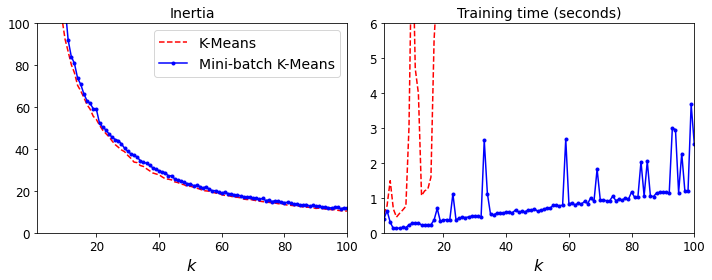

In [58]:
plt.figure(figsize=(10,4))

# 왼편 그림
plt.subplot(121)

plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")            # 빨강 파선
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means") # 파랑 실선

plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

# 오른편 그림
plt.subplot(122)

plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")            # 빨강 파선
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means") # 파랑 실선

plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### 최적의 군집수
지금까지 사용한 예제에 대해 군집수를 5보다 작거나 크게 하면 아래와 같은 일이 발생한다.

Saving figure bad_n_clusters_plot


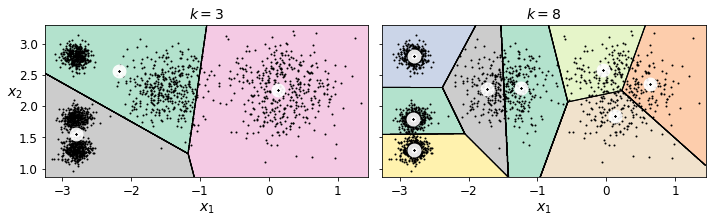

In [59]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)  # 3개의 군집
kmeans_k8 = KMeans(n_clusters=8, random_state=42)  # 8개의 군집

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

#### 관성 활용
별로 좋아보이지 않는다. 그런데 관성은 군집수가 커질수록 줄어든다.

In [60]:
kmeans_k3.inertia_

653.216719002155

In [61]:
kmeans_k8.inertia_

119.11983416102879

실제로 군집수가 많아질 수록 관성은 줄어든다. 이유는 센트로이드 수가 늘어날 수록 각 샘플과 센트로이드 사이의 거리는 줄어들 수밖에 없기 때문이다. 아래 코드가 이 사실을 잘 보여준다.

- $k$가 1부터 9까지 변하는 동안 훈련된 모델의 관성을 측정한다.

In [62]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

- 군집수와 측정된 관성 사이의 관계를 선그래프로 그리면 다음과 같다.

Saving figure inertia_vs_k_plot


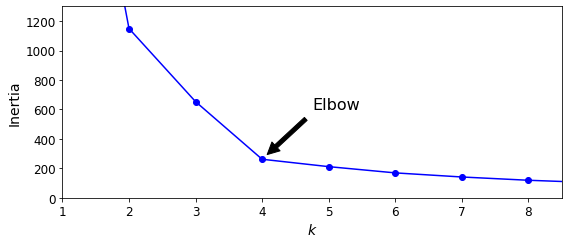

In [63]:
plt.figure(figsize=(8, 3.5))

# 군집수와 관성 관계
plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

# 주석 작성: Elbow 단어와 화살표 표시
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

실루엣 점수 활용
실루엣 점수(silhouette score)는 각 훈련 샘플에 대한 실루엣 계수(silhouette coefficient)의 평균값이다. 실루엣 계수는 아래와 같이 계산된다.

$$ \frac {b - a}{max(a,b)} $$

- a: 동일 군집 내의 다른 샘플과의 거리의 평균값
- b: 가장 가까운 타 군집 샘플과의 거리의 평균값

실루엣 계수는 -1과 1 사이의 값이며, 의미는 다음과 같다.

- 1에 가까울 때: 해당 인스턴스가 속하는 군집의 한 센트로이드에 가깝게 위치함.
- 0에 가까울 때: 해당 인스턴스가 속하는 군집의 경계에 가깝게 위치함.
- 1에 가까울 때: 해당 인스턴스가 속하는 군집이 아닌 다른 군집의 센트로이드에 가깝게 위치함. 즉, 잘못된 군집에 속함.

아래 코드는 군집수가 증가할 때 실루엣 점수의 변화를 보여준다.

In [64]:
from sklearn.metrics import silhouette_score

In [65]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


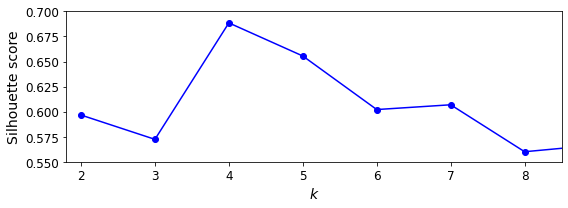

In [66]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

$k=4$가 여전히 매우 좋아 보인다. 하지만 관성의 경우와는 달리 $k=5$도 역시 꽤 좋다는 것을 알 수 있다.

군집별로 각 샘플의 실루엣 계수를 오름차순으로 정렬한 그래프인 **실루엣 다이어그램(silhouette diagram)**이 보다 많은 정보를 전달한다.

Saving figure silhouette_analysis_plot


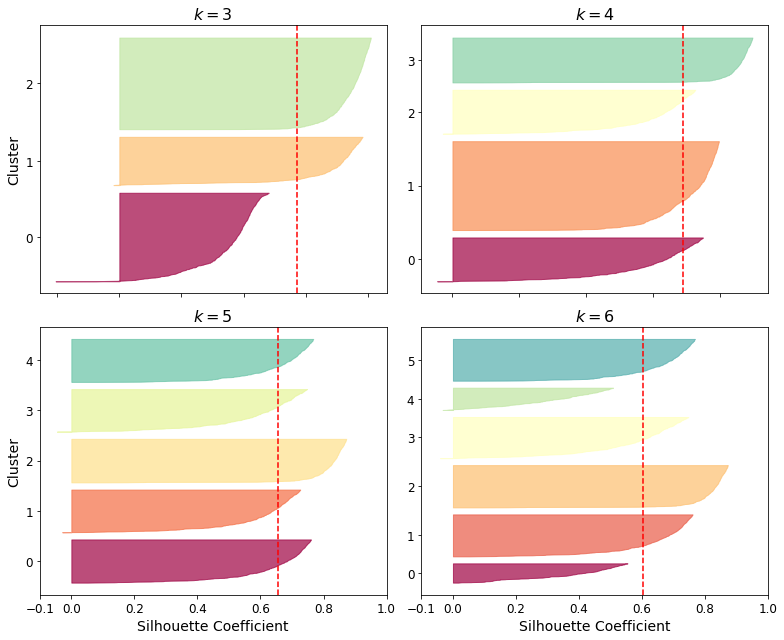

In [67]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

$k=5$인 경우가 가장 좋아 보인다. 이유는 모든 군집이 거의 비슷한 크기이고, 모든 군집의 칼날이 실루엣 점수(빨강 파선)넘어서고 있기 때문이다.

### k-평균의 한계
k-평균의 가장 큰 단점은 최적의 군집수를 확인하기 위해 알고리즘을 여러 번 실행해야 한다는 점이다. 또한 군집의 크기와 밀도가 서로 다른거나 원형이 아닌 경우 k-평균 모델이 제대로 작동하지 않을 수 있다.

아래 코드는 타원 모양의 군집으로 이루어진 데이터셋을 생성한다.

In [68]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

산점도를 그리면 아래와 같다.

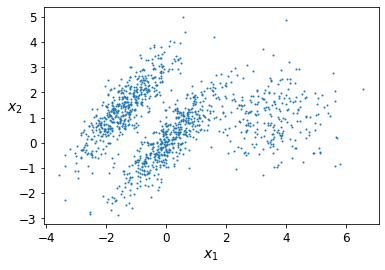

In [69]:
plot_clusters(X)

먼저 알고 있는 센트로이드 정보를 이용하여 좋은 k-평균 모델을 훈련한다.

In [70]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_good.fit(X)

KMeans(init=array([[-1.5,  2.5],
       [ 0.5,  0. ],
       [ 4. ,  0. ]]),
       n_clusters=3, n_init=1, random_state=42)

이번엔 센트로이드를 무작위로 지정한다.

In [71]:
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

두 모델의 훈련 결과는 다음과 같다. 오른편 모델은 형편없다. 반면에 왼편 모델은 보다 좋지만 그래도 25%정도의 데이터가 오른쪽 군집에 잘못 할당되었다.

Saving figure bad_kmeans_plot


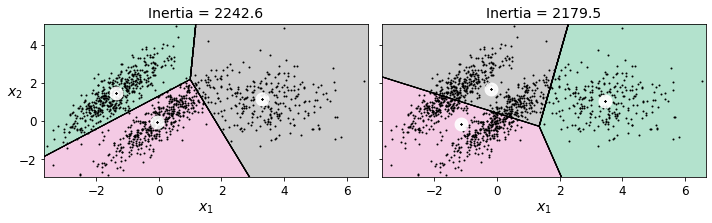

In [72]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

#### 특성 스케일링 활용
특성 스케일링을 하면 군집 구분이 보다 명확해지고 보다 원형에 가까운 군집이 생성되어 k-평균 모델의 성능이 보다 좋아질 수 있다.

### 군집화 활용: 이미지 색상 분할
이미지 색상 분할은 유사한 색상을 동일한 군집에 연결하는 기법을 의미한다. 색상 분할 과정을 살펴보기 위해 무당벌레 이미지를 하나 다운로드한다.

In [73]:
# 무당벌레 이미지 다운로드
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

filename = "ladybug.png"
print("Downloading", filename)

url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fc3e36e4790>)

다운로드된 이미지는 `533 x 800` 픽셀 크기의 칼라 사진이다.